In [1]:
import os
import csv
import glob
import numpy as np                  # For doing math
import matplotlib
import matplotlib.pyplot as plt     # For plotting
import matplotlib.dates as mdates   # For formatting dates when plotting
import matplotlib.colors as colors  # For truncating colorbars
import matplotlib.style as style
import matplotlib.units as munits
import xarray as xr                 # For dealing with netCDF data
import cartopy.crs as ccrs          # For plotting maps
import cartopy.feature as cfeature  # For plotting maps
import pandas as pd                 # A quick way to deal with time stamps
import netCDF4 as nc                # Another way to deal with netCDF data

import metpy.calc as mpcalc
import datetime
import scipy.interpolate
import scipy.signal as sig
import scipy.stats as stats
import sys
import scipy.io as sio

import cartopy.crs as ccrs          # For plotting maps
import cartopy.feature as cfeature  # For plotting maps

from netCDF4 import Dataset
from xarray import DataArray

from scipy.optimize import curve_fit
# from netCDF4 import Dataset
from matplotlib import colors as mcolors
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from scipy.signal import savgol_filter
from scipy.stats import binned_statistic
from matplotlib.gridspec import GridSpec
from numpy.random import seed
from numpy.random import rand
from datetime import datetime
from wrf import (getvar, interplevel, vertcross, 
                 vinterp, ALL_TIMES, extract_global_attrs)

print('Done importing modules now')

import warnings
warnings.filterwarnings('ignore')

Done importing modules now


In [2]:
def getheights(ds):
    '''
    From a dataset of wrfout files, calculate height above the surface
    '''

    heights3d_stag = (ds['PH'].isel(Time=1) + ds['PHB'].isel(Time=1))/9.81 - ds['HGT'].isel(Time=1).values
    heights_stag = heights3d_stag.mean(('south_north', 'west_east')).values

    heights_destag = []
    for i in range(len(heights_stag)-1):
        heights_destag.append(0.5*(heights_stag[i]+heights_stag[i+1]))
    heights_destag = np.array(heights_destag)

    return heights_destag

In [3]:
def destagger(var, stagger_dim):
    '''
    From wrf-python https://github.com/NCAR/wrf-python/blob/b40d1d6e2d4aea3dd2dda03aae18e268b1e9291e/src/wrf/destag.py 
    '''
    var_shape = var.shape
    num_dims = var.ndim
    stagger_dim_size = var_shape[stagger_dim]

    full_slice = slice(None)
    slice1 = slice(0, stagger_dim_size - 1, 1)
    slice2 = slice(1, stagger_dim_size, 1)

    dim_ranges_1 = [full_slice] * num_dims
    dim_ranges_2 = [full_slice] * num_dims

    dim_ranges_1[stagger_dim] = slice1
    dim_ranges_2[stagger_dim] = slice2

    result = .5*(var[tuple(dim_ranges_1)] + var[tuple(dim_ranges_2)])

    return result

## Opening the wrfout files

In [17]:
# Define directories to read in and open as xarray

DIR = '/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#1/'
DIR_label=DIR[(DIR.find('ICA_12') + 7):]
filenames = sorted([f for f in glob.glob(DIR+"/wrfout_d01_*")])

ds = xr.open_mfdataset(filenames, 
                       concat_dim = 'Time',
                      combine = 'nested',
                      parallel=True)
times = ds['XTIME'].values


# height_1 = getheights(ds_1)
# u_1 = destagger(ds_1['U'], 3)
# v_1 = destagger(ds_1['V'], 2)


# print('U:',np.shape(u_1))
# print('V:',np.shape(v_1))
# print('Height:',np.shape(height_1))

In [18]:
print(times)

['2021-08-25T00:00:00.000000000' '2021-08-25T03:00:00.000000000'
 '2021-08-25T06:00:00.000000000' '2021-08-25T09:00:00.000000000'
 '2021-08-25T12:00:00.000000000' '2021-08-25T15:00:00.000000000'
 '2021-08-25T18:00:00.000000000' '2021-08-25T21:00:00.000000000'
 '2021-08-26T00:00:00.000000000' '2021-08-26T03:00:00.000000000'
 '2021-08-26T06:00:00.000000000' '2021-08-26T09:00:00.000000000'
 '2021-08-26T12:00:00.000000000' '2021-08-26T15:00:00.000000000'
 '2021-08-26T18:00:00.000000000' '2021-08-26T21:00:00.000000000'
 '2021-08-27T00:00:00.000000000' '2021-08-27T03:00:00.000000000'
 '2021-08-27T06:00:00.000000000' '2021-08-27T09:00:00.000000000'
 '2021-08-27T12:00:00.000000000' '2021-08-27T15:00:00.000000000'
 '2021-08-27T18:00:00.000000000' '2021-08-27T21:00:00.000000000'
 '2021-08-28T00:00:00.000000000' '2021-08-28T03:00:00.000000000'
 '2021-08-28T06:00:00.000000000' '2021-08-28T09:00:00.000000000'
 '2021-08-28T12:00:00.000000000' '2021-08-28T15:00:00.000000000'
 '2021-08-28T18:00:00.000

## Tracking the Path

In [19]:
psfc = ds['PSFC']

In [26]:
print(np.shape(psfc))
psfc = np.squeeze(psfc)
print(np.shape(psfc))

(57, 302, 395)
(57, 302, 395)


In [25]:
print(psfc[1,1,1])

<xarray.DataArray 'PSFC' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    XLAT     float32 dask.array<chunksize=(), meta=np.ndarray>
    XLONG    float32 dask.array<chunksize=(), meta=np.ndarray>
    XTIME    datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  SFC PRESSURE
    units:        Pa
    stagger:      


In [5]:
# loop through the files and read in the u, v, height, and time 

pressure =[]
for f in filenames :
    print('Reading ',f)
    ds = nc.Dataset(f)
    pressure.append(ds['PSFC'])
pressure = np.squeeze(pressure)

Reading  /projects/jiko1138/ATOC_3030/Project/Ida/Simulation#1/wrfout_d01_2021-08-25_00:00:00
Reading  /projects/jiko1138/ATOC_3030/Project/Ida/Simulation#1/wrfout_d01_2021-08-25_03:00:00
Reading  /projects/jiko1138/ATOC_3030/Project/Ida/Simulation#1/wrfout_d01_2021-08-25_06:00:00
Reading  /projects/jiko1138/ATOC_3030/Project/Ida/Simulation#1/wrfout_d01_2021-08-25_09:00:00
Reading  /projects/jiko1138/ATOC_3030/Project/Ida/Simulation#1/wrfout_d01_2021-08-25_12:00:00
Reading  /projects/jiko1138/ATOC_3030/Project/Ida/Simulation#1/wrfout_d01_2021-08-25_15:00:00
Reading  /projects/jiko1138/ATOC_3030/Project/Ida/Simulation#1/wrfout_d01_2021-08-25_18:00:00
Reading  /projects/jiko1138/ATOC_3030/Project/Ida/Simulation#1/wrfout_d01_2021-08-25_21:00:00
Reading  /projects/jiko1138/ATOC_3030/Project/Ida/Simulation#1/wrfout_d01_2021-08-26_00:00:00
Reading  /projects/jiko1138/ATOC_3030/Project/Ida/Simulation#1/wrfout_d01_2021-08-26_03:00:00
Reading  /projects/jiko1138/ATOC_3030/Project/Ida/Simulation

In [7]:
print(np.shape(pressure))

(57, 302, 395)


In [9]:
pressure = pressure/100
print(pressure[1,1,1])

1013.5145


## Tracking Hurricanes

In [2]:
import os
import csv
import glob
import numpy as np                  # For doing math
import matplotlib.pyplot as plt     # For plotting
import matplotlib.dates as mdates   # For formatting dates when plotting
import matplotlib.colors as colors  # For truncating colorbars
import matplotlib.style as style
import xarray as xr                 # For dealing with netCDF data
import cartopy.crs as ccrs          # For plotting maps
import cartopy.feature as cfeature  # For plotting maps
import pandas as pd                 # A quick way to deal with time stamps
import wrf
from wrf import (getvar, interplevel, vertcross, 
                 vinterp, ALL_TIMES, extract_global_attrs)
from netCDF4 import Dataset

In [2]:
### Import data
ds = xr.open_dataset("/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#1/wrfout_d01_2021-08-25_00:00:00")

In [3]:
lats = ds['XLAT'].isel(Time=0)    # Note: we must index-select Time=0 because plots expect 2D data (lat-lon)
longs = ds['XLONG'].isel(Time=0)

In [4]:
min_lat = ds['XLAT'].values.min()
max_lat = ds['XLAT'].values.max()
min_lon = ds['XLONG'].values.min()
max_lon = ds['XLONG'].values.max()
MAP_BOUNDS = [min_lon, max_lon, min_lat, max_lat]
print('Done getting data')

Done getting data


In [5]:
# Read in the no-wind-farm files just to get elevation for the turbine plots
WRF_DIRECTORY_NWF = "/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#1"
WRF_FILES_NWF = sorted([f for f in glob.glob(WRF_DIRECTORY_NWF+"/wrfout_d01_*")])
# WRF_FILES_NWF = WRF_FILES_NWF[32:42]
_WRF_FILES_NWF = [os.path.abspath(
    os.path.join(WRF_DIRECTORY_NWF, f)) for f in WRF_FILES_NWF]

In [6]:
min_slp_lats = np.zeros(len(WRF_FILES_NWF))
min_slp_longs = np.zeros(len(WRF_FILES_NWF))

In [7]:
# Check that the WRF files exist
try:
    for f in _WRF_FILES_NWF:
        if not os.path.exists(f):
            raise ValueError("{} does not exist. "
                "Check for typos or incorrect directory.".format(f))

except ValueError as e:
    # Try downloading then check again
    os.system("git submodule init")
    os.system("git submodule update")
    os.system("GIT_DIR={}/.git git checkout -- .".format(WRF_DIRECTORY_NWF))
    for f in _WRF_FILES_NWF:
        if not os.path.exists(f):
             raise e

In [8]:
# Create functions so that the WRF files only need
# to be specified using the WRF_FILES global above

def single_wrf_file_nwf():
    global _WRF_FILES_NWF
    return _WRF_FILES_NWF[0]

def multiple_wrf_files_nwf():
    global _WRF_FILES_NWF
    return _WRF_FILES_NWF

In [9]:
file_paths_nwf = multiple_wrf_files_nwf()
wrf_files_nwf = [Dataset(f) for f in file_paths_nwf]

In [ ]:
#ter = getvar(wrf_files_nwf, "ter", timeidx=ALL_TIMES, method='cat')
slp = getvar(wrf_files_nwf, "slp", timeidx=ALL_TIMES, method='cat')

In [ ]:
lats = getvar(wrf_files_nwf, "lat", timeidx=ALL_TIMES, method='cat')

In [ ]:
longs = getvar(wrf_files_nwf, "lon", timeidx=ALL_TIMES, method='cat')
#height_agl = getvar(wrf_files_nwf, "height_agl", timeidx=ALL_TIMES, method='cat')
print(np.shape(slp))

In [127]:
## Sea Level Presures: only three datasets are plotted here. Students will need to repeat all of these steps for each of the datasets
# For the first case
min_slp = slp.min(dim=('south_north', 'west_east')).values
fix_slp = slp[:,100:200,113:165]

for i in range(len(WRF_FILES_NWF)): 
    #print(slp.isel(Time=i).where(slp.isel(Time=i)==slp.isel(Time=i).min(), drop=True).squeeze()['XLAT'].values)
    min_slp_lats[i] = fix_slp.isel(Time=i).where(fix_slp.isel(Time=i)==fix_slp.isel(Time=i).min(), drop=True).squeeze()['XLAT'].values
    min_slp_longs[i] = fix_slp.isel(Time=i).where(fix_slp.isel(Time=i)==fix_slp.isel(Time=i).min(), drop=True).squeeze()['XLONG'].values
    
print(min_slp)
print(min_slp_longs, min_slp_lats)

[972.4895  975.16504 975.5326  971.3599  971.3888  974.7602  974.16724
 972.2985  971.72046 972.4441 ]
[array(-93.527, dtype=float32), array(-93.527, dtype=float32), array(-93.527, dtype=float32), array(-93.527, dtype=float32), array(-93.527, dtype=float32), array(-93.527, dtype=float32), array(-93.620476, dtype=float32), array(-93.99438, dtype=float32), array(-94.461754, dtype=float32), array(-94.92912, dtype=float32)] [array(25.15377, dtype=float32), array(25.238358, dtype=float32), array(26.499931, dtype=float32), array(26.91745, dtype=float32), array(28.078224, dtype=float32), array(28.571915, dtype=float32), array(28.981575, dtype=float32), array(29.55236, dtype=float32), array(30.039062, dtype=float32), array(30.603882, dtype=float32)]


/projects/jiko1138/software/anaconda/envs/tutorial_2021/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/projects/jiko1138/software/anaconda/envs/tutorial_2021/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


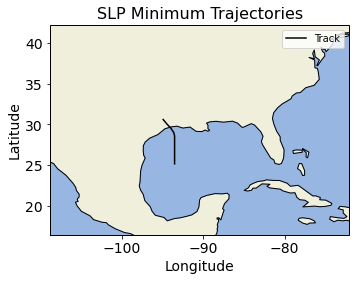

In [128]:
### Plot terrain
# Create figure and axes objects
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())
# Bound and fill in nice lines
ax.set_extent(MAP_BOUNDS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)
# One line for each dataset to plot - ADD MORE HERE
ax.plot(min_slp_longs, min_slp_lats, color='k', label='Track')       # color='k', k = black

# Add important info to the plot
ax.legend()
ax.set_title("SLP Minimum Trajectories", fontsize=16)
ax.xaxis.set_visible(True)    # Set xaxis visible because cartopy hides it by default
ax.yaxis.set_visible(True)
ax.tick_params(labelsize=14)
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
# Adjust figure height so the xlabel isn't cut off when saved
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("trajectories.png")
plt.savefig("trajectories.pdf")
plt.show()

## Tracking the Path

In [13]:
import os
import csv
import glob
import numpy as np                  # For doing math
import matplotlib.pyplot as plt     # For plotting
import matplotlib.dates as mdates   # For formatting dates when plotting
import matplotlib.colors as colors  # For truncating colorbars
import matplotlib.style as style
import xarray as xr                 # For dealing with netCDF data
import cartopy.crs as ccrs          # For plotting maps
import cartopy.feature as cfeature  # For plotting maps
import pandas as pd                 # A quick way to deal with time stamps
import wrf
from wrf import (getvar, interplevel, vertcross, 
                 vinterp, ALL_TIMES, extract_global_attrs)
from netCDF4 import Dataset

In [14]:
ds = xr.open_dataset("/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#2/wrfout_d01_2021-08-25_00:00:00")
lats = ds['XLAT'].isel(Time=0)    # Note: we must index-select Time=0 because plots expect 2D data (lat-lon)
longs = ds['XLONG'].isel(Time=0)
min_lat = ds['XLAT'].values.min()
max_lat = ds['XLAT'].values.max()
min_lon = ds['XLONG'].values.min()
max_lon = ds['XLONG'].values.max()
MAP_BOUNDS = [min_lon, max_lon, min_lat, max_lat]
times = ds['XTIME'].values
print(MAP_BOUNDS)

[-108.85689, -72.02777, 16.425804, 40.822296]


In [15]:
WRF_DIRECTORY_NWF = "/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#2"
WRF_FILES_NWF = sorted([f for f in glob.glob(WRF_DIRECTORY_NWF+"/wrfout_d01_*")])
_WRF_FILES_NWF = [os.path.abspath(
                  os.path.join(WRF_DIRECTORY_NWF, f)) for f in WRF_FILES_NWF]

In [16]:
nc_fid = Dataset("/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#2/wrfout_d01_2021-08-25_00:00:00", 'r')
desired_lon = nc_fid.getncattr('CEN_LON')
desired_lat = nc_fid.getncattr('CEN_LAT')

In [26]:
# Define empty array of SLP lats and longs
min_slp_xtime=[]
min_slp_longs=[]
min_slp_lats=[]
min_slp=[]
# Loop through each file

for f in WRF_FILES_NWF :
#   print(f)
    df  = Dataset(f)
    slp = getvar(df,"slp", 
                 method='cat')
    slp = slp[20:200,123:265]
    xtime = getvar(df,"Times")
    print(np.shape(slp))
    print(xtime.values)
    min_slp_xtime.append(xtime)

    min_slp.append(slp.min().values)
    
    this_lat  = slp.where(slp==slp.min(), drop=True).squeeze()['XLAT'].values
    this_long = slp.where(slp==slp.min(), drop=True).squeeze()['XLONG'].values
    
    min_slp_lats.append(this_lat)
    min_slp_longs.append(this_long)
#     min_slp_lats.append(slp.isel(Time=0).where(slp.isel(Time=i)==slp01_04_04_01_01.isel(Time=i).min(), drop=True).squeeze()['XLAT'].values
#     min_slp_longs[i] = slp01_04_04_01_01.isel(Time=i).where(slp01_04_04_01_01.isel(Time=i)==slp01_04_04_01_01.isel(Time=i).min(), drop=True).squeeze()['XLONG'].values

# Do something cool with the lats and longs

(180, 142)
2021-08-25T00:00:00.000000000
(180, 142)
2021-08-25T03:00:00.000000000
(180, 142)
2021-08-25T06:00:00.000000000
(180, 142)
2021-08-25T09:00:00.000000000
(180, 142)
2021-08-25T12:00:00.000000000
(180, 142)
2021-08-25T15:00:00.000000000
(180, 142)
2021-08-25T18:00:00.000000000
(180, 142)
2021-08-25T21:00:00.000000000
(180, 142)
2021-08-26T00:00:00.000000000
(180, 142)
2021-08-26T03:00:00.000000000
(180, 142)
2021-08-26T06:00:00.000000000
(180, 142)
2021-08-26T09:00:00.000000000
(180, 142)
2021-08-26T12:00:00.000000000
(180, 142)
2021-08-26T15:00:00.000000000
(180, 142)
2021-08-26T18:00:00.000000000
(180, 142)
2021-08-26T21:00:00.000000000
(180, 142)
2021-08-27T00:00:00.000000000
(180, 142)
2021-08-27T03:00:00.000000000
(180, 142)
2021-08-27T06:00:00.000000000
(180, 142)
2021-08-27T09:00:00.000000000
(180, 142)
2021-08-27T12:00:00.000000000
(180, 142)
2021-08-27T15:00:00.000000000
(180, 142)
2021-08-27T18:00:00.000000000
(180, 142)
2021-08-27T21:00:00.000000000
(180, 142)
2021-

In [73]:
### Read Read Data

In [27]:
data = pd.read_csv('/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#1/Savings/Ida_Real_Data.csv') 

,SEASON,BASIN,SUBBASIN,ISO_TIME_________,NATURE,LAT,LON,DIST2LAND,LANDFALL,IFLAG,...,USA R50,USA R64,USA POCI,USA ROCI,USA RMW,USA GUST,USA SEAHGT,USA SEARAD,STORM SPEED,STORM DIR
0,2021,NaN,CS,2021-08-24 6:00:00,NR,11.80,-64.20,134,134.0,O_____________,...,NaN,NaN,1011,120,90,NaN,NaN,NaN,22,276
1,2021,NaN,CS,9:00:00,NR,11.91,-65.30,164,149.0,P_____________,...,NaN,NaN,1010,120,90,NaN,NaN,NaN,22,275
2,2021,NaN,CS,12:00:00,NR,12.00,-66.40,156,141.0,O_____________,...,NaN,NaN,1010,120,90,NaN,NaN,NaN,22,274
3,2021,NaN,CS,15:00:00,NR,12.05,-67.50,132,84.0,P_____________,...,NaN,NaN,1009,120,90,NaN,NaN,NaN,22,273
4,2021,NaN,CS,18:00:00,NR,12.10,-68.60,81,31.0,O_____________,...,NaN,NaN,1009,120,90,NaN,NaN,NaN,22,274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2021,NaN,NaN,18:00:00,ET,39.20,-78.30,0,0.0,O_____________,...,NaN,NaN,1008,480,210,40.0,NaN,NaN,26,66
69,2021,NaN,NaN,21:00:00,ET,39.55,-76.91,0,0.0,P_____________,...,NaN,NaN,1004,305,167,NaN,NaN,NaN,22,74
70,2021,NaN,NaN,2021-09-02 0:00:00,ET,39.80,-75.60,0,0.0,O_____________,...,NaN,NaN,1001,130,125,45.0,NaN,NaN,21,73
71,2021,NaN,NaN,3:00:00,ET,40.16,-74.23,0,0.0,P_____________,...,NaN,NaN,1001,142,137,NaN,NaN,NaN,23,70


In [28]:
rwsp = data['STORM SPEED'].tolist()
rlat = data['LAT'].tolist()
rlon = data['LON'].tolist()
print(np.shape(rlon))

print(np.shape(min_slp_longs))

(73,)
(57,)


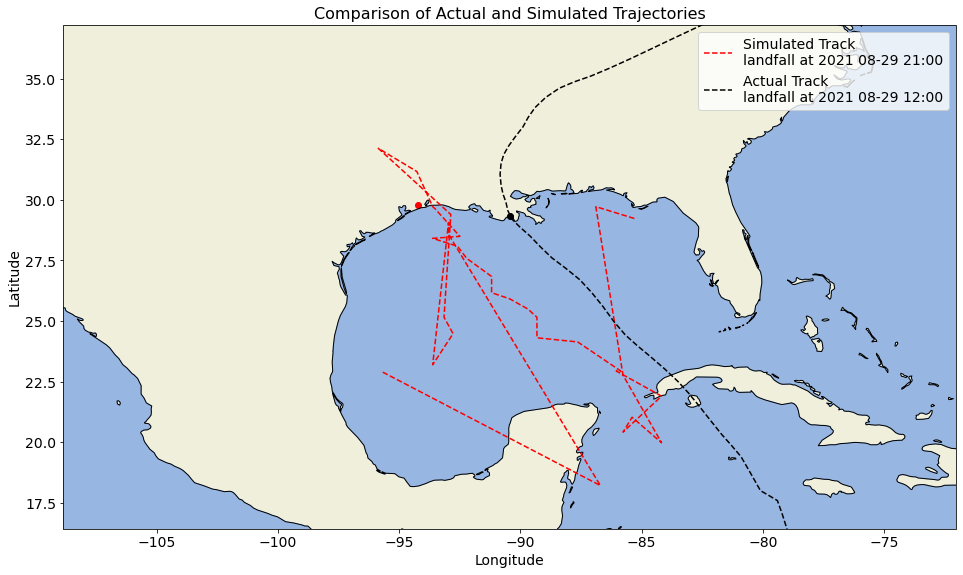

In [29]:
### Plot terrain
# Create figure and axes objects
fig, ax = plt.subplots(1,1,figsize=(16,10), sharex=True, sharey=True)
ax = plt.axes(projection=ccrs.PlateCarree())

# Bound and fill in nice lines
MAP_BOUNDS = [min_lon, max_lon, min_lat, max_lat]
FIXED_BOUNDS = [min_lon, max_lon, min_lat, max_lat-5]

ax.set_extent(FIXED_BOUNDS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)
# One line for each dataset to plot - ADD MORE HERE"
line1, = ax.plot(min_slp_longs[19:51], min_slp_lats[19:51], 
        color='r', label=r'Simulated Track'
                         '\n'
                         'landfall at 2021 08-29 21:00', linestyle='dashed')  
ax.scatter(-94.21200, 
           29.768834, 
           color='r')


line2, = ax.plot(rlon[1:], rlat[1:], color='k', label=r'Actual Track'
                                                       '\n'
                                                       'landfall at 2021 08-29 12:00', linestyle='dashed')      
ax.scatter([desired_lon], 
           [desired_lat], 
            color='k')
# Add important info to the plot
ax.legend()
ax.set_title("Comparison of Actual and Simulated Trajectories", fontsize=16)
ax.xaxis.set_visible(True)    # Set xaxis visible because cartopy hides it by default
ax.yaxis.set_visible(True)
ax.tick_params(labelsize=14)


ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
# Adjust figure height so the xlabel isn't cut off when saved
ax.legend(prop={'size': 14})

plt.show()